Import Necessary Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import geopandas as gpd
from tqdm import tqdm
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.ops import nearest_points

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## Read the normalized dataset

In [6]:
#Mounting from data assets Azure ML
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("data_gradient", version="1")
ml_client.data.mount("azureml://subscriptions/230da710-78c2-4cc1-9e21-36bccff41cae/resourcegroups/RESEARCH-DEVELOPMENT/workspaces/aml-development/datastores/workspaceblobstore/paths/UI/2024-08-22_071335_UTC/normalized_data_minmax.csv",  "/tmp/gradient1")


Found the config file in: /config.json


Resolving credential...
trying to get token from DefaultAzureCredential
resolved DefaultAzureCredential to ManagedIdentityCredential
resolved ManagedIdentityCredential to AzureMLCredential
trying to get token from AzureMLCredential
Resolved credential.
Mount starting...
Subprocess PID: 5708
Mount started successfully.
To unmount, run `$ umount /tmp/gradient1`.
Logs can be found at /tmp/azureml-logs/dataprep/rslex-fuse-cli


,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,...,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal),Nearest Basement,Nearest Volcano,Volcanic domain,Volcanic weight,Gradient Weight,sample_weight
0,4.216078,-74.888898,0.100557,0.899443,21.294394,0.720455,0.359897,0.053527,0.102362,0.022877,...,0.642857,0.341539,0.096100,0.241172,0.107926,0.034629,True,1,0.025810,0.025810
1,4.214720,-74.891220,0.101535,0.898465,23.783404,0.720641,0.359897,0.054497,0.102794,0.022201,...,0.642857,0.341539,0.096100,0.241172,0.107145,0.034457,True,1,0.025460,0.025460
2,0.606276,-76.564731,0.088329,0.911671,24.156323,0.412171,0.515283,0.121886,0.168226,0.112310,...,0.357143,0.467743,0.319461,0.615321,0.173626,0.081206,False,4,0.025460,0.101840
3,0.305911,-76.914853,0.029052,0.970948,25.601245,0.483869,0.521874,0.126023,0.144177,0.097701,...,0.357143,0.460502,0.316090,0.628522,0.176712,0.093585,False,4,0.030197,0.120787
4,0.287539,-76.911964,0.095470,0.904530,26.559722,0.477817,0.521874,0.130004,0.149747,0.101809,...,0.357143,0.460502,0.360872,0.644461,0.181525,0.095853,False,4,0.043282,0.173128


In [7]:
#read data
filename = "/tmp/gradient1/normalized_data_minmax.csv"
cleaned_data= pd.read_csv(filename)
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,...,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal),Nearest Basement,Nearest Volcano,Volcanic domain,Volcanic weight,Gradient Weight,sample_weight
0,4.216078,-74.888898,0.100557,0.899443,21.294394,0.720455,0.359897,0.053527,0.102362,0.022877,...,0.642857,0.341539,0.096100,0.241172,0.107926,0.034629,True,1,0.025810,0.025810
1,4.214720,-74.891220,0.101535,0.898465,23.783404,0.720641,0.359897,0.054497,0.102794,0.022201,...,0.642857,0.341539,0.096100,0.241172,0.107145,0.034457,True,1,0.025460,0.025460
2,0.606276,-76.564731,0.088329,0.911671,24.156323,0.412171,0.515283,0.121886,0.168226,0.112310,...,0.357143,0.467743,0.319461,0.615321,0.173626,0.081206,False,4,0.025460,0.101840
3,0.305911,-76.914853,0.029052,0.970948,25.601245,0.483869,0.521874,0.126023,0.144177,0.097701,...,0.357143,0.460502,0.316090,0.628522,0.176712,0.093585,False,4,0.030197,0.120787
4,0.287539,-76.911964,0.095470,0.904530,26.559722,0.477817,0.521874,0.130004,0.149747,0.101809,...,0.357143,0.460502,0.360872,0.644461,0.181525,0.095853,False,4,0.043282,0.173128


In [8]:
#Manual from path 
# cleaned_data = pd.read_csv('normalized_data_minmax.csv')
# cleaned_data.head()

In [10]:
#for weights on algorithm
weights = cleaned_data['sample_weight']

## Correlation Matrix

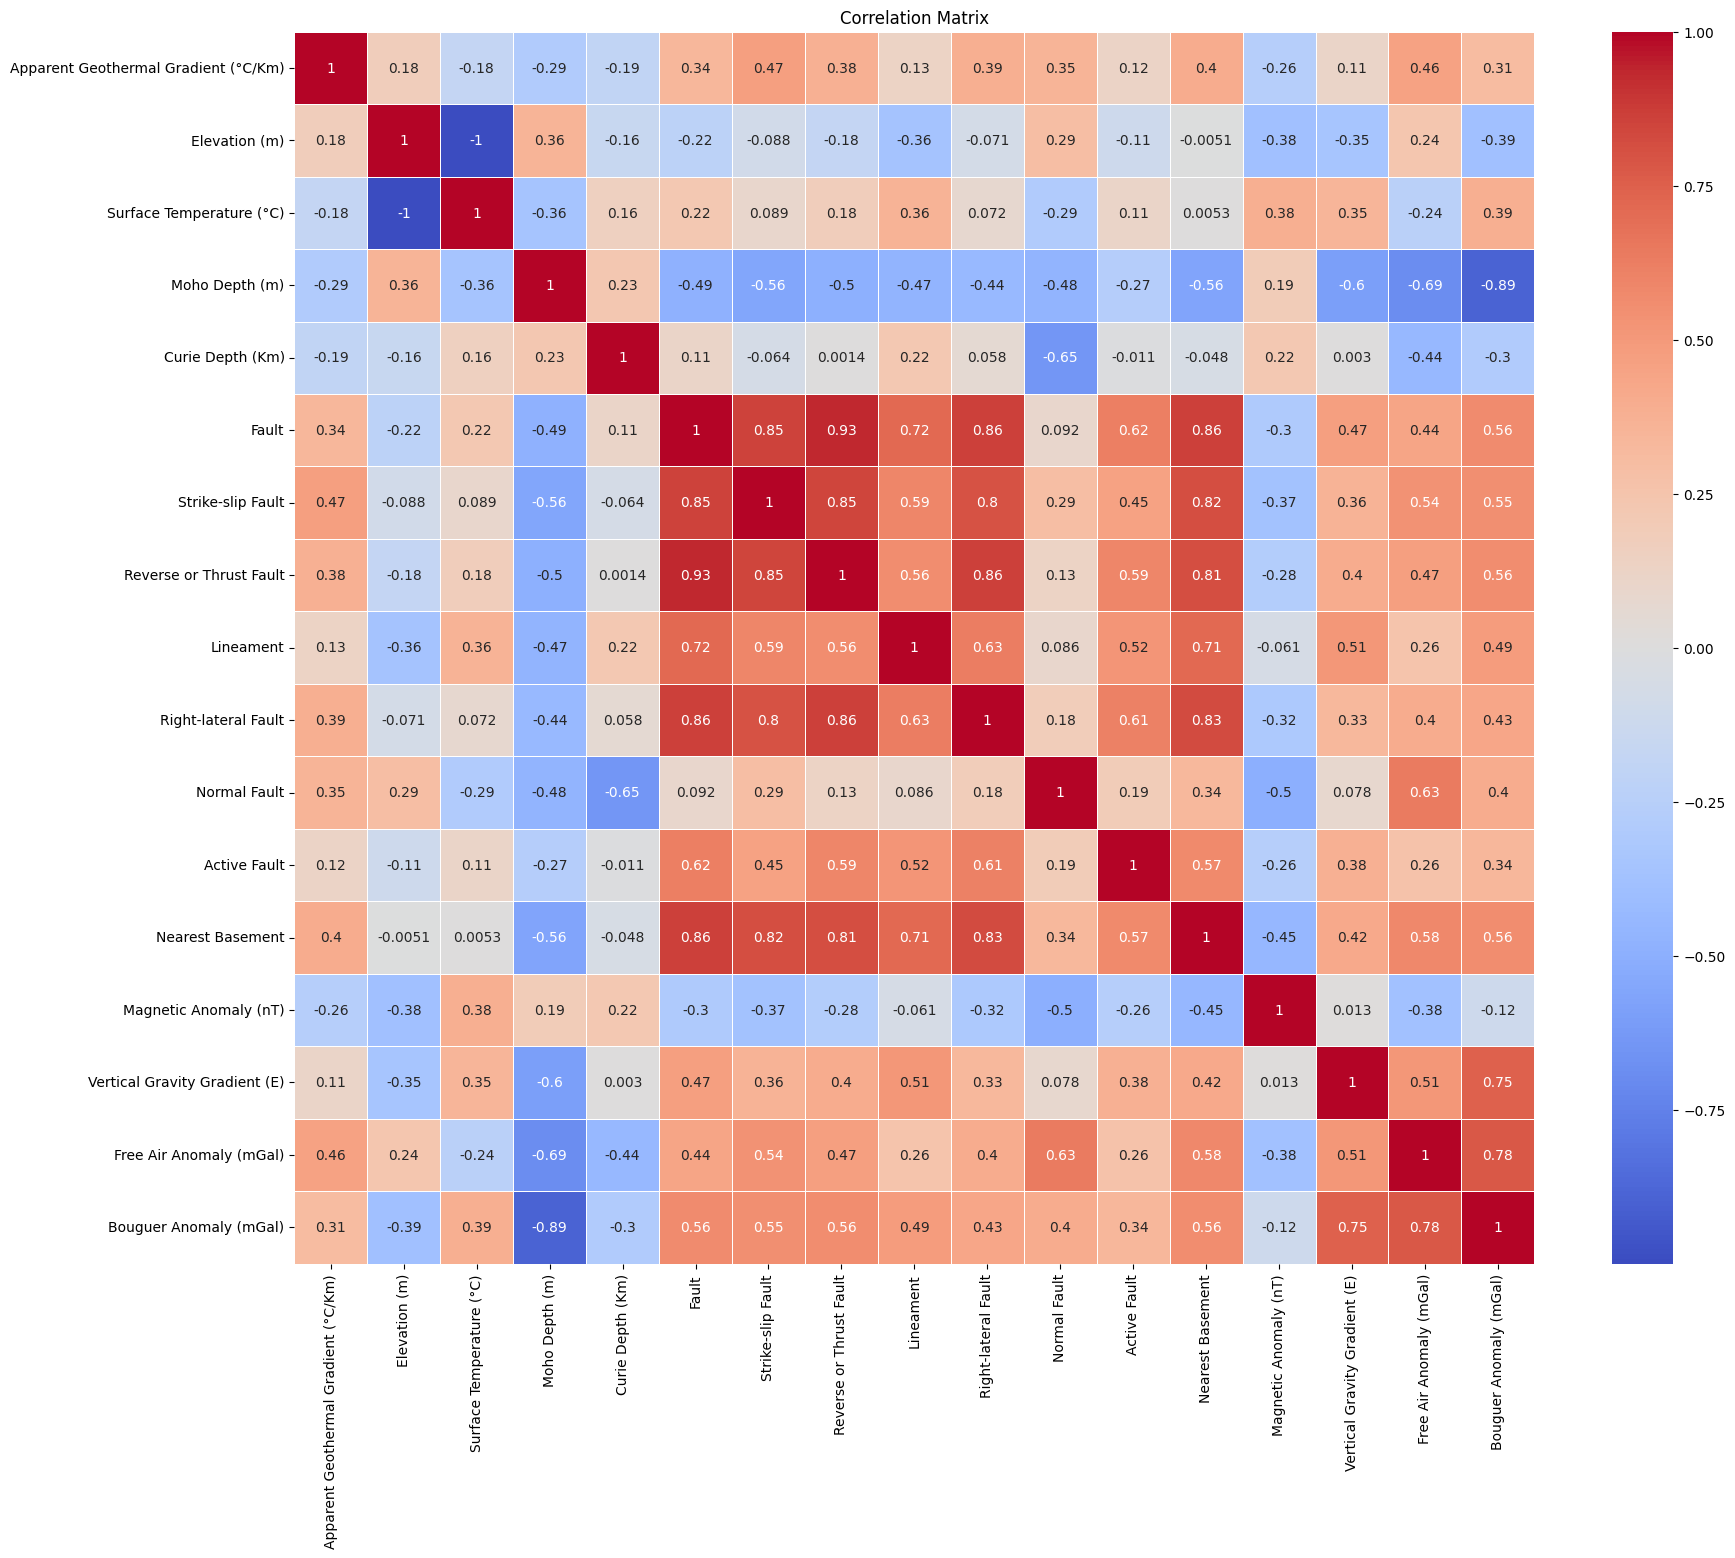

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the desired columns
selected_columns = ['Apparent Geothermal Gradient (°C/Km)', 
       'Elevation (m)', 'Surface Temperature (°C)',
       'Moho Depth (m)', 'Curie Depth (Km)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Nearest Basement', 
       'Magnetic Anomaly (nT)', 'Vertical Gravity Gradient (E)', 
       'Free Air Anomaly (mGal)','Bouguer Anomaly (mGal)']

# Create a DataFrame with the selected columns
selected_data = cleaned_data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Building Machine Learning Algorithm

## Data Splitting

In [12]:
cleaned_data.columns

Index(['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)', 'Moho Depth (m)',
       'Magnetic Anomaly (nT)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Curie Depth (Km)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)', 'Nearest Basement', 'Nearest Volcano',
       'Volcanic domain', 'Volcanic weight', 'Gradient Weight',
       'sample_weight'],
      dtype='object')

In [13]:
# Reduce the importance of the free air anomaly
cleaned_data['Free Air Anomaly (mGal)'] = cleaned_data['Free Air Anomaly (mGal)'] * 0.25

In [14]:
# Define feature matrix (X) and target variables (y)
X = cleaned_data[['Latitude', 'Longitude', 'Elevation (m)',
       'Curie Depth (Km)','Moho Depth (m)', 
       'Strike-slip Fault', 'Reverse or Thrust Fault', 
       'Right-lateral Fault', 'Nearest Basement',
       'Normal Fault', 'Active Fault','Magnetic Anomaly (nT)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)']]

y = cleaned_data['Apparent Geothermal Gradient (°C/Km)']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test, weights_train, _ = train_test_split(X, y, weights, test_size=0.2)

# Save X_test with lat and lon for plotting later
X_test_with_lat_lon = X_test[['Latitude', 'Longitude']].copy()

# Save X with lat and lon for plotting later
X_lat_lon = X[['Latitude', 'Longitude']].copy()

# Remove lat and lon from X to predict on the whole dataset
X = X.drop(['Latitude', 'Longitude'], axis=1)

#Remove lat and lon from X_train and X_test
X_train = X_train.drop(['Latitude', 'Longitude'], axis=1)
X_test = X_test.drop(['Latitude', 'Longitude'], axis=1)

## Hyperparameter Tuning

Manually iterating over hyperparameter combinations and recording the progress using the tqdm library. 

In [47]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import numpy as np
from tqdm import tqdm

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 0.15, 0.3],
    'min_child_weight': [1, 5, 10],
    'colsample_bytree': [0.1, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 2],
    'subsample': [0.5, 0.7, 1],
}

best_params = {}
best_mse = float('inf')

# Use tqdm to display a progress bar
total_combinations = len(list(ParameterGrid(param_grid)))
with tqdm(total=total_combinations) as pbar:
    for params in ParameterGrid(param_grid):
        # Initialize the XGBRegressor with the current set of parameters
        xgb_model = xgb.XGBRegressor(**params)
        # Fit the model using the training data, target, and sample weights
        xgb_model.fit(X_train, y_train, sample_weight=weights_train)
        # Predict on the test set
        y_pred = xgb_model.predict(X_test)
        # Calculate the mean squared error on the test set
        mse = mean_squared_error(y_test, y_pred)
        # If the calculated MSE is lower than the best MSE, update the best parameters and best MSE
        if mse < best_mse:
            best_params = params
            best_mse = mse
        # Update the progress bar
        pbar.update(1)

print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_mse)

100%|██████████| 6561/6561 [14:52<00:00,  7.35it/s]


Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'reg_alpha': 0.5, 'reg_lambda': 2, 'subsample': 1}
Best Mean Squared Error: 15.192715150803554


In [29]:
# best_params = {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 1}

## Train XGBoost and evaluate model

In [48]:
best_xgb_model = xgb.XGBRegressor(**best_params, n_estimators=100)
best_xgb_model.fit(X_train, y_train, sample_weight=weights_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [49]:
import joblib
joblib.dump(best_xgb_model, 'trained_model.pkl')

['trained_model.pkl']

In [50]:
import joblib
best_xgb_model = joblib.load('trained_model.pkl')

Evaluate the model's performance on the test data using appropriate regression metrics (e.g., MAE, RMSE, R-squared).

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on the training set
y_train_pred = best_xgb_model.predict(X_train)

# Metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)

print("Training Set Metrics:")
print(f"MAE: {mae_train}")
print(f"RMSE: {rmse_train}")
print(f"R-squared: {r2_train}")

Training Set Metrics:
MAE: 1.8354342184186707
RMSE: 2.4840560605641975
R-squared: 0.7698886244737277


In [52]:
# Predictions on the test set
y_test_pred = best_xgb_model.predict(X_test)

# Metrics for the test set
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

print("\nTest Set Metrics:")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R-squared: {r2_test}")


Test Set Metrics:
MAE: 2.7151192443704257
RMSE: 3.8977833637599146
R-squared: 0.45767909990580957


# Visualization of results

In [53]:
y_pred = y_test_pred

## Residual Plot

Create a residual plot to check if the model's predictions have a pattern. Most residuals must be near to zero

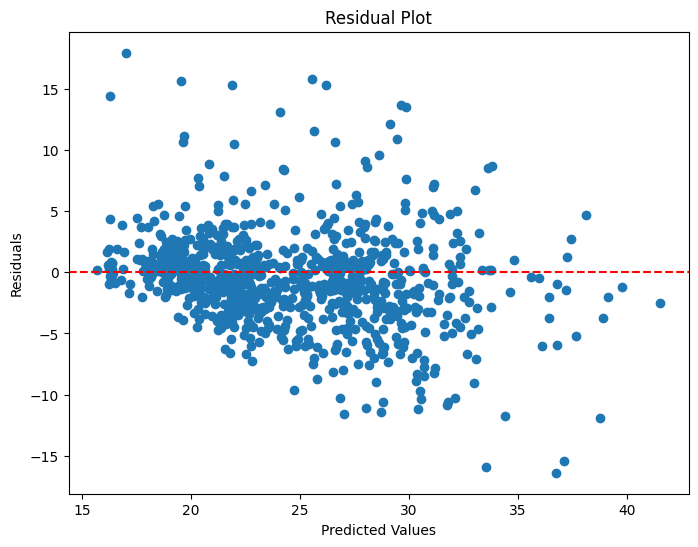

In [54]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.show()

## Actual vs. Predicted Plot

Visualize how model's predictions compare to the actual values.

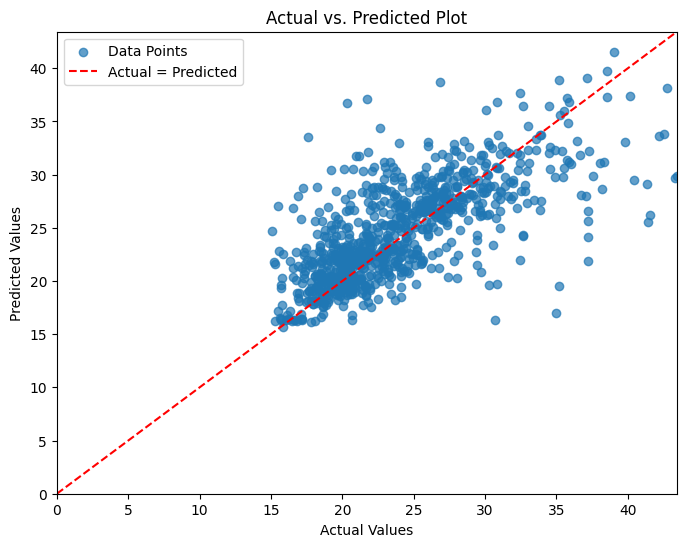

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Data Points', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Plot')

# Set x and y axis limits to start at 0,0
plot_max = max(max(y_test), max(y_pred))
plt.xlim(0, plot_max)
plt.ylim(0, plot_max)

# Plot the line where Actual = Predicted
plt.plot([0, plot_max], [0, plot_max], color='red', linestyle='--', label='Actual = Predicted')

plt.legend()
plt.show()

## Feature Importance Plot

Visualize the importance of each feature in the Random Forest model. This will help to understand which features have the most significant impact on predicting the geothermal gradient.

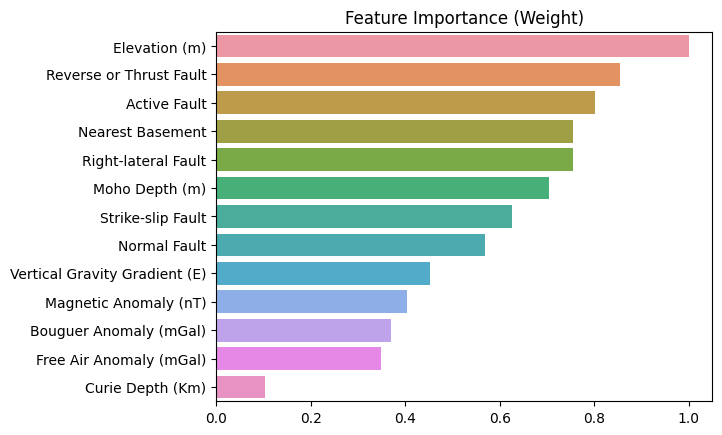

In [38]:
importance_weight = best_xgb_model.get_booster().get_score(importance_type='weight')

importance_weight = {k: v / max(importance_weight.values()) for k, v in importance_weight.items()}
importance_weight = dict(sorted(importance_weight.items(), key=lambda item: item[1]))
importance_weight = dict(reversed(list(importance_weight.items())))

sns.barplot(x=list(importance_weight.values()), y=list(importance_weight.keys()))

plt.title('Feature Importance (Weight)')
plt.show()

## Regression results

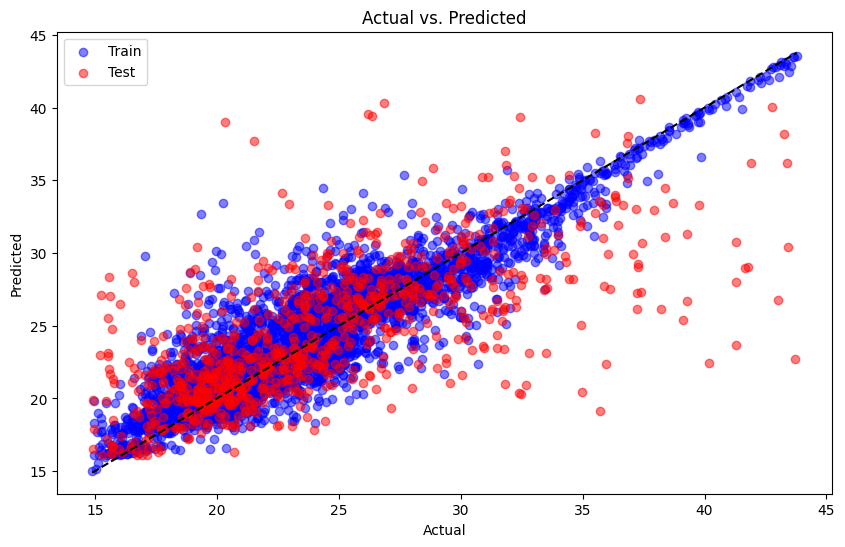

In [43]:
import matplotlib.pyplot as plt

# Use the model to make predictions on the training and test sets
y_train_pred = best_xgb_model.predict(X_train)
y_pred = best_xgb_model.predict(X_test)

# Create a scatter plot of the actual vs. predicted values for the training set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Train', alpha=0.5)

# Create a scatter plot of the actual vs. predicted values for the test set
plt.scatter(y_test, y_pred, color='red', label='Test', alpha=0.5)

# Plot a line for perfect fit
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')

# Set the labels and title
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.legend()

# Show the plot
plt.show()

## Geospatial visualization

### Actual data

In [44]:
import geopandas as gpd

In [45]:
actual_data = pd.read_csv('normalized_data_minmax.csv')

In [46]:
actual_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,...,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal),Nearest Basement,Nearest Volcano,Volcanic domain,Volcanic weight,Gradient Weight,sample_weight
0,4.216078,-74.888898,0.100557,0.899443,21.294394,0.720455,0.359897,0.053527,0.102362,0.022877,...,0.642857,0.341539,0.096100,0.241172,0.107926,0.034629,True,1,0.025810,0.025810
1,4.214720,-74.891220,0.101535,0.898465,23.783404,0.720641,0.359897,0.054497,0.102794,0.022201,...,0.642857,0.341539,0.096100,0.241172,0.107145,0.034457,True,1,0.025460,0.025460
2,0.606276,-76.564731,0.088329,0.911671,24.156323,0.412171,0.515283,0.121886,0.168226,0.112310,...,0.357143,0.467743,0.319461,0.615321,0.173626,0.081206,False,4,0.025460,0.101840
3,0.305911,-76.914853,0.029052,0.970948,25.601245,0.483869,0.521874,0.126023,0.144177,0.097701,...,0.357143,0.460502,0.316090,0.628522,0.176712,0.093585,False,4,0.030197,0.120787
4,0.287539,-76.911964,0.095470,0.904530,26.559722,0.477817,0.521874,0.130004,0.149747,0.101809,...,0.357143,0.460502,0.360872,0.644461,0.181525,0.095853,False,4,0.043282,0.173128


### Predicted data

In [47]:
# Make predictions using the entire dataset (X)
y_pred_full = best_xgb_model.predict(X)

# Update your existing DataFrame or create a new one to store the predictions
X_lat_lon['Predicted Geothermal Gradient (°C/Km)'] = y_pred_full

In [48]:
X_lat_lon.head()

,Latitude,Longitude,Predicted Geothermal Gradient (°C/Km)
0,4.216078,-74.888898,27.403076
1,4.214720,-74.891220,27.681402
2,0.606276,-76.564731,24.446003
3,0.305911,-76.914853,25.162207
4,0.287539,-76.911964,27.935265


In [49]:
X_lat_lon.to_csv('predicted_dataset.csv', index=False)

In [50]:
X_lat_lon = pd.read_csv('predicted_dataset.csv')

### Plot actual and predicted

/tmp/ipykernel_21619/1562596514.py:41: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


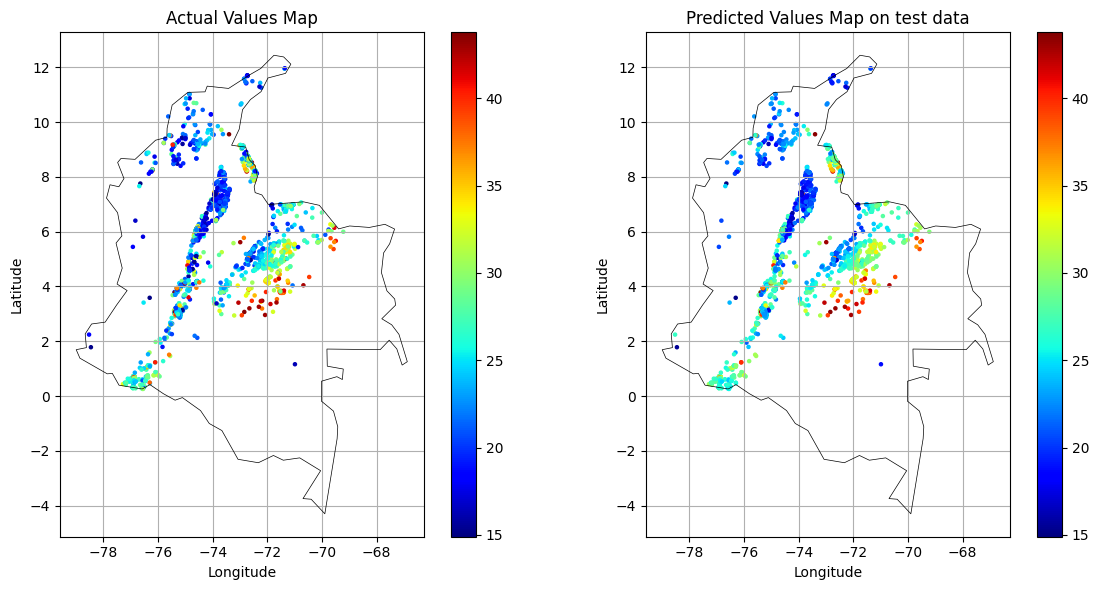

In [51]:
# Load GeoDataFrame for actual values
actual_gdf = gpd.GeoDataFrame(actual_data, geometry=gpd.points_from_xy(actual_data['Longitude'], actual_data['Latitude']))

# Load GeoDataFrame for predicted values
predicted_gdf = gpd.GeoDataFrame(X_lat_lon, geometry=gpd.points_from_xy(X_lat_lon['Longitude'], X_lat_lon['Latitude']))

# Determine the common color range
vmin = min(actual_gdf['Apparent Geothermal Gradient (°C/Km)'].min(), predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].min())
vmax = max(actual_gdf['Apparent Geothermal Gradient (°C/Km)'].max(), predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].max())

# Create subplots with two axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cmap = 'jet'

# Plot actual values on the first subplot
actual_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap=cmap, markersize=5, legend=True, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('Actual Values Map')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot predicted values on the second subplot
predicted_plot = predicted_gdf.plot(column='Predicted Geothermal Gradient (°C/Km)', cmap=cmap, markersize=5, legend=True, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('Predicted Values Map on test data')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon to both subplots
for ax in axes:
    ax.set_xticks(lon_grid)
    ax.set_yticks(lat_grid)
    ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest for both subplots
for ax in axes:
    world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the combined plot with both subplots
plt.tight_layout()
plt.show()
